In [ ]:
!nvidia-smi

Sat Feb  6 12:32:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install gdown
!pip install tensorflow_text

     |████████████████████████████████| 3.4MB 8.3MB/s 


In [ ]:
!pip install wordcloud

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 40kB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
#sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear') 
  plt.title(title) 
  plt.axis("off") 
  plt.show()

In [ ]:
dataset = pd.read_csv('raw_data.csv')
headline = dataset.iloc[:,2].values
sentiment = dataset.iloc[:,4].values

In [ ]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [ ]:
sent_1 = ["the location is great"]
sent_2 = ["amazing location"]

emb_1 = use(sent_1)
emb_2 = use(sent_2)

In [ ]:
emb_1.shape

TensorShape([1, 512])

In [ ]:
np.inner(emb_1, emb_2).flatten()[0]

0.7925468

# Preprocessing

In [ ]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    headline, 
    sentiment, 
    test_size=.1, 
    random_state=RANDOM_SEED
  )

In [ ]:
X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 3664/3664 [02:13<00:00, 27.41it/s]


In [ ]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 408/408 [00:14<00:00, 27.53it/s]


In [ ]:
print(X_train.shape, X_test.shape)

(3664, 512) (408, 512)


In [ ]:
print(y_train.shape, y_test.shape)

(3664,) (408,)


# Sentiment Analysis

In [ ]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
207/207 [==============================] - 1s 4ms/step - loss: 0.5893 - accuracy: 0.6792 - val_loss: 0.4095 - val_accuracy: 0.8038
Epoch 2/10
207/207 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.8065 - val_loss: 0.3944 - val_accuracy: 0.8256
Epoch 3/10
207/207 [==============================] - 0s 2ms/step - loss: 0.3711 - accuracy: 0.8352 - val_loss: 0.3704 - val_accuracy: 0.8229
Epoch 4/10
207/207 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8525 - val_loss: 0.3691 - val_accuracy: 0.8392
Epoch 5/10
207/207 [==============================] - 0s 2ms/step - loss: 0.3041 - accuracy: 0.8730 - val_loss: 0.3574 - val_accuracy: 0.8420
Epoch 6/10
207/207 [==============================] - 0s 2ms/step - loss: 0.2862 - accuracy: 0.8778 - val_loss: 0.3724 - val_accuracy: 0.8420
Epoch 7/10
207/207 [==============================] - 0s 2ms/step - loss: 0.2463 - accuracy: 0.9041 - val_loss: 0.3806 - val_accuracy: 0.8392
Epoch 

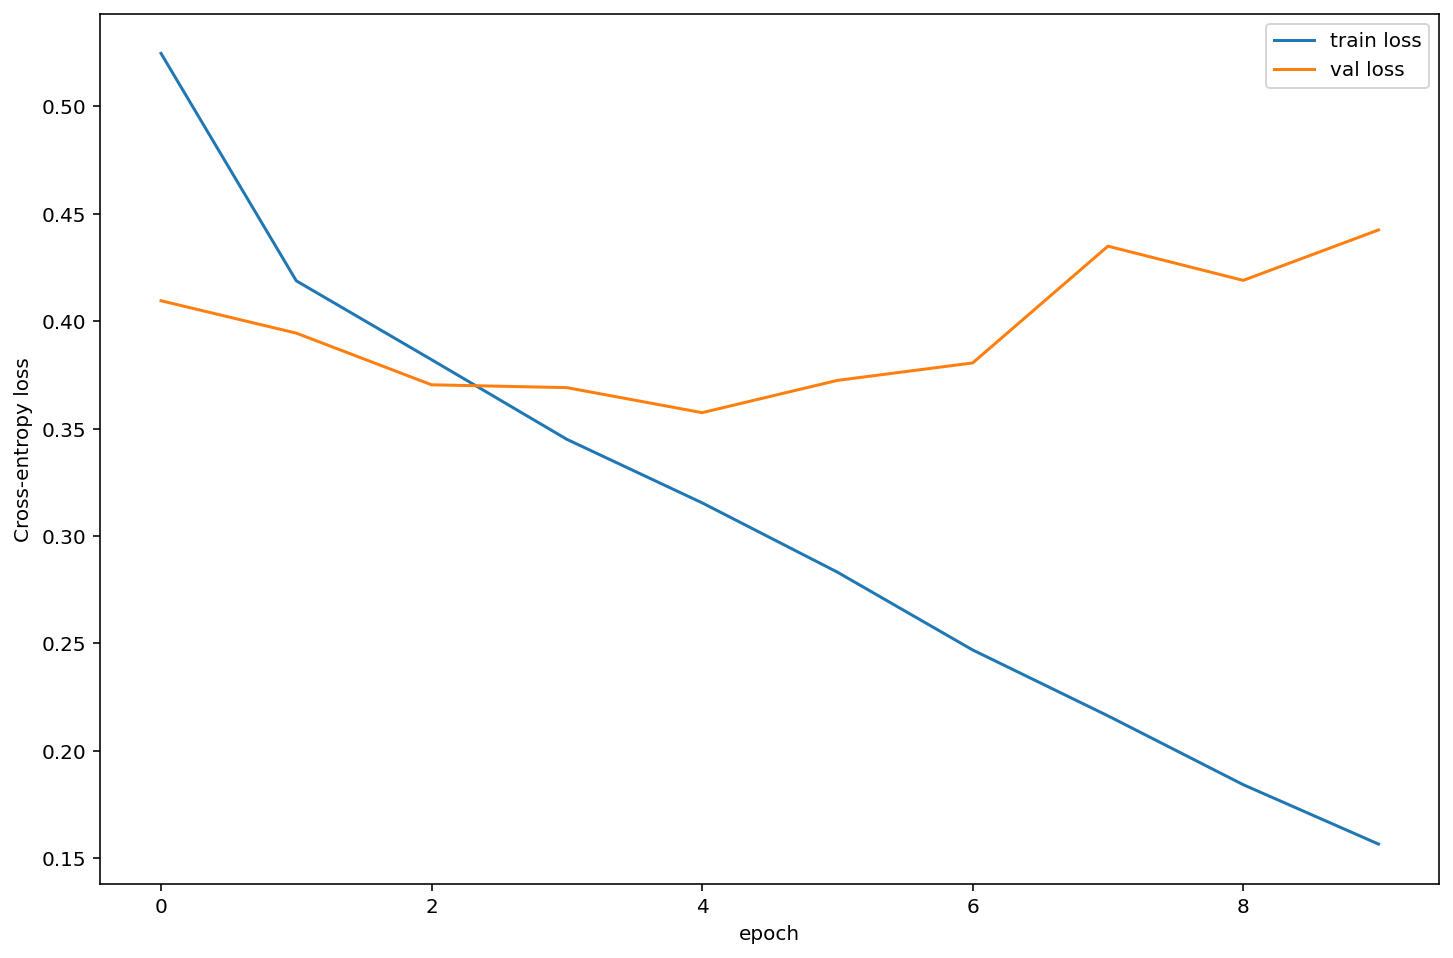

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

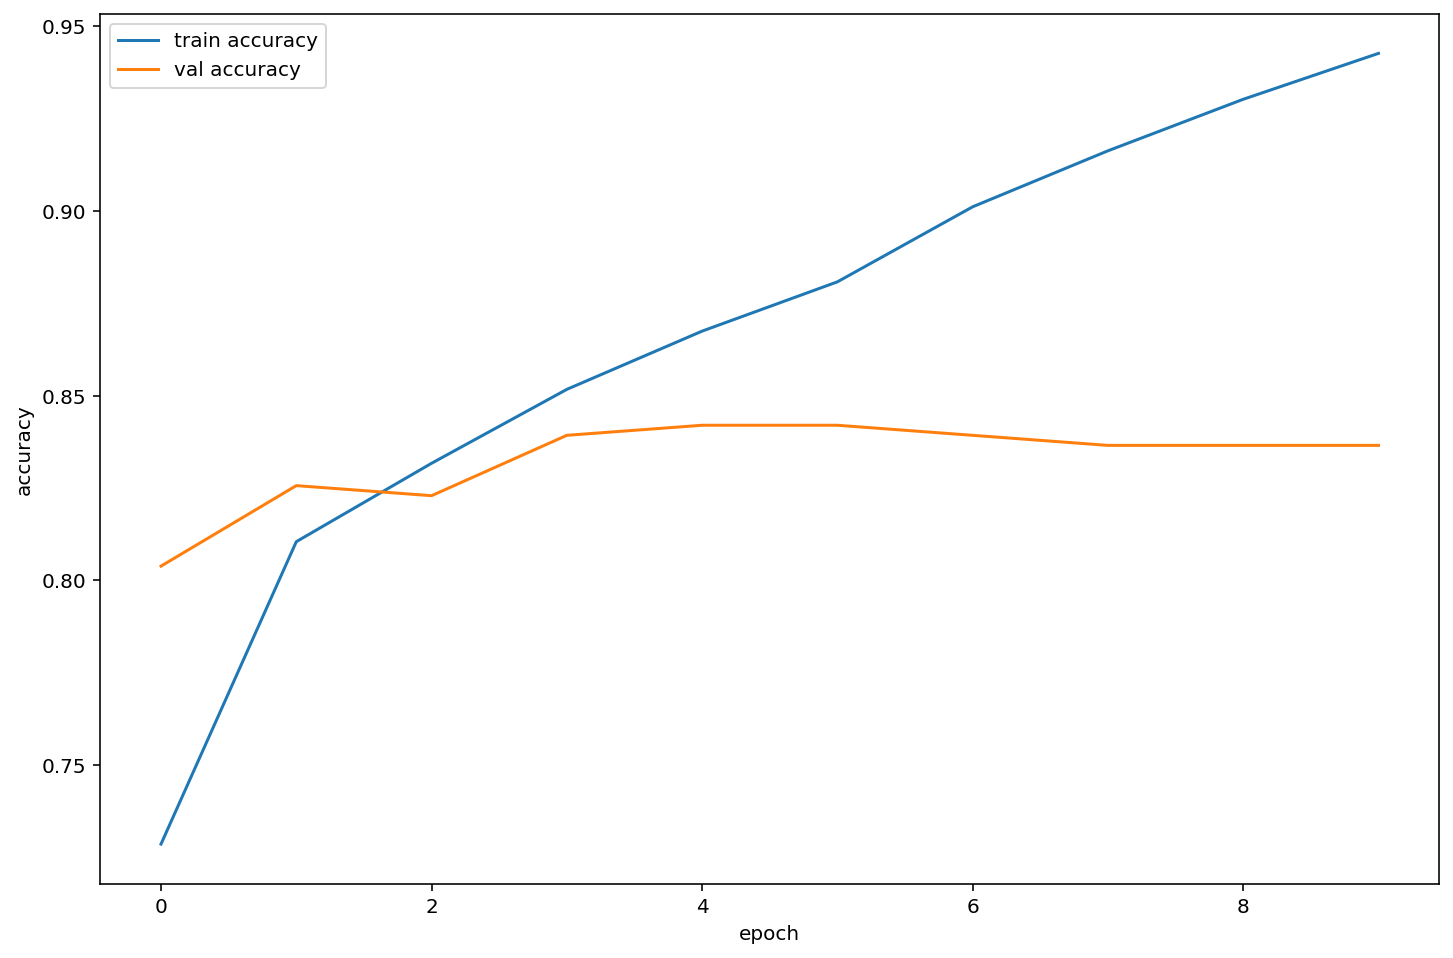

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 1ms/step - loss: 0.5180 - accuracy: 0.7966


[0.5179859399795532, 0.7965686321258545]

# Predictions

In [ ]:
text = "FC Kohli, father of India’s IT revolution, is no more"
pred = []
pred.append(text)
X_test1 = []
for r in tqdm(pred):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test1.append(review_emb)

X_test1 = np.array(X_test1)

100%|██████████| 1/1 [00:00<00:00, 25.52it/s]


In [ ]:
result = model.predict(X_test1)
#res = np.argmax(result)
if result<0.5:
  print('Negative')
elif result==0.5:
  print('Neutral')
else:
  print('Positive')
print(result)

Negative
[[0.21978617]]
